In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Fathest Point Sampling

### Example

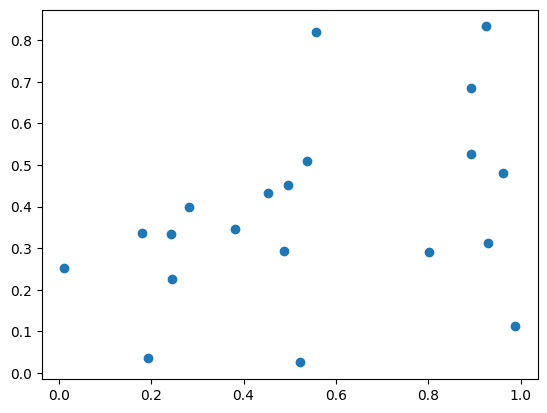

In [5]:
n_points = 20
test_data = np.random.random([n_points, 2])

plt.scatter(test_data[:, 0], test_data[:, 1])
plt.show()

In [6]:
n_sample = 10

point_ids = np.arange(n_points)
first_point_id = np.random.randint(0, n_points)
centroid = np.zeros([n_sample], dtype='int')

centroid[0] = first_point_id

for i in range(n_sample-1):
    last_added_id = centroid[i]
    point_ids = point_ids[np.where(point_ids != last_added_id)[0]]
    last_added_point = test_data[last_added_id]
    remain_points = test_data[point_ids]
    distance = np.linalg.norm(remain_points - last_added_point, axis=1)
    fathest_idx = np.argmax(distance)

    centroid[i+1] = point_ids[fathest_idx]

print(centroid)

[19  0  7 17 11 18  4  9 10 16]


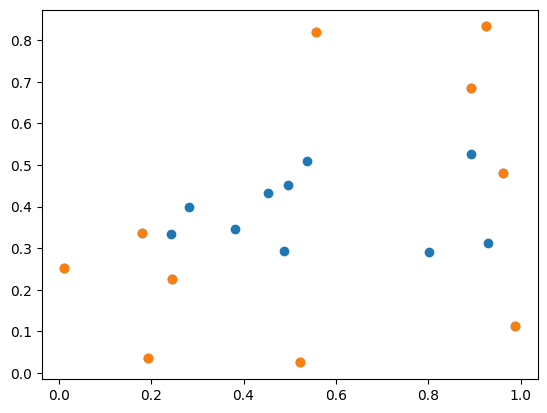

In [7]:
plt.scatter(test_data[:, 0], test_data[:, 1])
plt.scatter(test_data[centroid, 0], test_data[centroid, 1])
plt.show()

### Tensorflow implementation

In [78]:
def fathest_point_sampling(xyz, n_points):
    """
    xyz: tensor [batch size, num points, num dimension]
    n_points: number of sampling points
    """
    B, N, D = xyz.shape
    centroid_ids = tf.random.uniform([B, 1], minval=0, maxval=N-1, dtype=tf.int64)
    mask = tf.ones([B, N], dtype=tf.float32)
    for i in range(n_points-1):
        added_id = centroid_ids[:, i]
        added_id_tf = [[b, added_id[b]] for b in range(B)]
        added_point = tf.reshape(tf.gather_nd(xyz, added_id_tf), [B, 1, D])
        dist = tf.math.reduce_euclidean_norm(xyz - added_point, axis=2)
        dist = dist * mask
        max_d_idx = tf.argmax(dist, axis=1)[..., tf.newaxis]

        centroid_ids = tf.concat([centroid_ids, max_d_idx], axis=1)
        mask = tf.math.minimum(dist * mask * 10e+10, mask)
    return centroid_ids

## Samplig and Grouping

In [79]:
B, N, D = 2, 10, 3
n_point = 3
r = 1.1
n_sample = 5

test = tf.random.normal([B, N, D])

In [93]:
def get_point_from_idx(xyz, idx):
    """
    xyz: tensor [B, N, D]
    idx: tensor [B, n_points] or [B, n_points, n_samples]

    return:
        [B, n_points, D] or [B, n_points, n_samples, D]
    """


    if len(idx.shape) == 2:
        B, n = idx.shape
        b_idx = tf.tile(tf.range(B, dtype=tf.int64)[..., tf.newaxis], [1, n])[..., tf.newaxis] # [B, n, 1]
        idx = idx[..., tf.newaxis]  # [B, n, 1]
        idx = tf.concat([b_idx, idx], axis=2)
    elif len(idx.shape) == 3:
        B, np, ns = idx.shape
        b_idx = tf.tile(tf.reshape(tf.range(B, dtype=tf.int32), [B, 1, 1]), [1, np, ns])[..., tf.newaxis] # [B, np, ns, 1]
        idx = idx[..., tf.newaxis]  # [B, n, 1]
        idx = tf.concat([b_idx, idx], axis=3)
    return tf.gather_nd(xyz, idx)


def query_ball_point(radius, n_samples, xyz, cent_xyz):
    """
    radius:
    n_samples:
    xyz: [B, N, D]
    cent_xyz: [B, n, D]

    return:
        [B, n_points, n_samples]
    """
    B, N, D = xyz.shape
    _, n, _ = cent_xyz.shape
    xyz = tf.reshape(test, [B, 1, N, D])
    cent_xyz = tf.reshape(cent_xyz, [B, n, 1, D])
    dist = tf.math.reduce_euclidean_norm(tf.tile(xyz, [1, n, 1, 1]) - cent_xyz, axis=3)
    r_mask = tf.ones([B, D, N]) * radius**2
    dist = tf.math.minimum(dist, r_mask)
    return tf.argsort(dist)[:, :, :n_samples]


def sample_and_group(xyz, n_points, n_samples, radius):
    """
    xyz: [B, N, D]
    n_points:
    n_sample:
    radius:

    return:
        [B, n_points, n_samples, D]
    """
    cent_idx = fathest_point_sampling(xyz, n_points)
    cent_xyz = get_point_from_idx(xyz, cent_idx)

    group_idx = query_ball_point(radius, n_samples, xyz, cent_xyz)
    group_xyz = get_point_from_idx(xyz, group_idx)
    return group_xyz

## Sampling, Grouping, and PointNet Layer

In [ ]:
class NonLinear(tf.keras.Model):
    def __init__(self, num_out: int, activation: str='relu', shared: bool=True, batchnormalization: bool=True):
        '''
        num_out: number of output
        shared: if shared is True, the 1d convolution is used
        '''
        super(NonLinear, self).__init__()
        self.batchnormalization = batchnormalization
        if shared:
            self.dense = tf.keras.layers.Conv1D(filters=num_out, kernel_size=1, strides=1)
        else:
            self.dense = tf.keras.layers.Dense(num_out)
        
        if batchnormalization:
            self.bn = tf.keras.layers.BatchNormalization()

        self.activation = tf.keras.layers.Activation(activation)

    def call(self, input):
        out = self.dense(input)
        if self.batchnormalization:
            out = self.bn(out)
        return self.activation(out)


In [ ]:
class SetAbstraction(tf.keras.Model):
    def __init__(self, n_points: int, n_samples: int, radius: float, mlps, activation: str='relu', batchnormalization: bool=True):
        super(SetAbstraction, self).__init__()
        self.n_points = n_points
        self.n_samples = n_samples
        self.radius = radius
        self.mlp_layers = []
        for mlp in mlps:
            self.mlp_layers.append(NonLinear(mlp, activation, batchnormalization=batchnormalization))
    
    def call(self, inputs):
        group_xyz = sample_and_group(inputs, self.n_points, self.n_samples, self.radius)

        for mlp in self.mlp_layers:
            group_xyz = mlp(group_xyz)
        return group_xyz

In [ ]:
import tensorflow as tf
x = tf.random.normal([2, 10, 3])
print(x)

InternalError: stream did not block host until done; was already in an error state

In [ ]:
nonliear = NonLinear(10)

In [ ]:
nonliear(x)

InternalError: Exception encountered when calling layer "batch_normalization_1" "                 f"(type BatchNormalization).

{{function_node __wrapped__FusedBatchNormV3_device_/job:localhost/replica:0/task:0/device:GPU:0}} cuDNN launch failure : input shape ([2,10,30,10]) [Op:FusedBatchNormV3]

Call arguments received by layer "batch_normalization_1" "                 f"(type BatchNormalization):
  • inputs=tf.Tensor(shape=(2, 10, 30, 10), dtype=float32)
  • training=None